## Classificação de Revisões do IMDb com Keras

In [1]:
from keras.datasets import imdb
from keras import preprocessing
import numpy as np
import pandas as pd

Using TensorFlow backend.


### Leitura dos dados

In [2]:
df = pd.read_csv('movie_data.csv.gz', encoding='utf-8')

In [3]:
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [4]:
samples = df["review"].values

In [5]:
dimensionality = 1000 #dimensão do vetor quer vai representar a palavra

### Constrói o índice de palavras

In [9]:
from keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=1000) 
tokenizer.fit_on_texts(samples) #constroi o índice de palavras

In [11]:
word_index = tokenizer.word_index
print('Foram encontrados %s tokens.' % len(word_index))

Foram encontrados 124252 tokens.


### Transforma strings em lista de índices inteiros

In [12]:
sequences = tokenizer.texts_to_sequences(samples) #transforma o texto em sequencias de índices 

In [13]:
sequences[0][:10] #os 10 primeiros índices da frase 0

[8, 1, 5, 1, 299, 710, 4, 20, 1, 316]

### Pre-processa sequencias para padronizar o tamanho

In [14]:
maxlen = 200
sequences_padding = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

In [15]:
len(sequences[10])

43

In [16]:
len(sequences_padding[10])

200

### Usando a camada Embedding e classificando os dados do IMDB

### SimpleRNN

#### Construindo o modelo

In [17]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Embedding, Dense, Input

In [18]:
original_dim = 10000 #numero de palavra para considerar como feature
new_dim = 32

In [19]:
model = Sequential()
model.add(Embedding(input_dim=dimensionality,input_length=maxlen,output_dim=new_dim))
model.add(SimpleRNN(new_dim, input_shape=(new_dim,),dropout=0.5))
model.add(Dense(1,activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 34,113
Trainable params: 34,113
Non-trainable params: 0
_________________________________________________________________


#### Compilando o modelo

In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

#### Dividindo os dados em treino e teste

In [22]:
import random 

In [23]:
size = len(sequences_padding)
indices = np.arange(size)
random.shuffle(indices)

In [24]:
indices

array([42782, 12893, 14864, ..., 16953, 24834, 34878])

In [25]:
x = sequences_padding[indices]
y = df.sentiment.values[indices]

In [26]:
x

array([[  0,   0,   0, ...,   9, 156, 156],
       [ 15, 264,   5, ..., 434, 489,   4],
       [  8,   1, 305, ...,   4,   1, 305],
       ...,
       [  0,   0,   0, ...,   9, 149, 158],
       [  0,   0,   0, ...,   8,   1, 580],
       [  0,   0,   0, ...,   5, 357,   9]])

In [27]:
y

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [28]:
treino = 0.8

x_treino = x[:int(treino*size),:]
y_treino = y[:int(treino*size)]
x_teste = x[int(treino*size):]
y_teste = y[int(treino*size):]

In [29]:
y_teste.shape

(10000,)

#### Treinando o modelo

In [30]:
history = model.fit(x_treino, y_treino, epochs=10, batch_size=256, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 10s 301us/step - loss: 0.5937 - acc: 0.6786 - val_loss: 0.6314 - val_acc: 0.6651
Epoch 2/10
32000/32000 [==============================] - 12s 380us/step - loss: 0.4495 - acc: 0.7966 - val_loss: 0.4221 - val_acc: 0.8103
Epoch 3/10
32000/32000 [==============================] - 11s 352us/step - loss: 0.4098 - acc: 0.8203 - val_loss: 0.4196 - val_acc: 0.8280
Epoch 4/10
32000/32000 [==============================] - 11s 339us/step - loss: 0.3962 - acc: 0.8275 - val_loss: 0.3837 - val_acc: 0.8380
Epoch 5/10
32000/32000 [==============================] - 11s 359us/step - loss: 0.3857 - acc: 0.8297 - val_loss: 0.3742 - val_acc: 0.8359
Epoch 6/10
32000/32000 [==============================] - 12s 364us/step - loss: 0.3748 - acc: 0.8386 - val_loss: 0.3778 - val_acc: 0.8394
Epoch 7/10
32000/32000 [==============================] - 11s 354us/s

#### Avaliando o modelo

In [31]:
evaluation = model.evaluate(x_teste,y_teste)

10000/10000 [==============================] - 3s 262us/step


#### Visualizando resultados

In [32]:
import  matplotlib.pyplot as plt

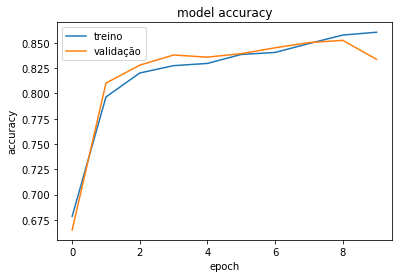

In [33]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

In [34]:
evaluation

[0.3715443476676941, 0.8336]

### Modelo LSTM

In [35]:
from keras.layers import LSTM, Dense, Masking, Embedding

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=dimensionality,input_length=maxlen,output_dim=new_dim))

# Recurrent layer
model.add(LSTM(new_dim, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(new_dim, activation='relu'))       


# Output layer
model.add(Dense(1, activation='sigmoid'))


In [36]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [37]:
history = model.fit(x_treino, y_treino, epochs=10, batch_size=256, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 34s 1ms/step - loss: 0.5394 - acc: 0.7414 - val_loss: 0.3964 - val_acc: 0.8250
Epoch 2/10
32000/32000 [==============================] - 34s 1ms/step - loss: 0.4015 - acc: 0.8236 - val_loss: 0.3821 - val_acc: 0.8304
Epoch 3/10
32000/32000 [==============================] - 38s 1ms/step - loss: 0.3790 - acc: 0.8380 - val_loss: 0.3722 - val_acc: 0.8395
Epoch 4/10
32000/32000 [==============================] - 37s 1ms/step - loss: 0.3689 - acc: 0.8426 - val_loss: 0.3649 - val_acc: 0.8399
Epoch 5/10
32000/32000 [==============================] - 33s 1ms/step - loss: 0.3605 - acc: 0.8477 - val_loss: 0.3582 - val_acc: 0.8474
Epoch 6/10
32000/32000 [==============================] - 34s 1ms/step - loss: 0.3532 - acc: 0.8509 - val_loss: 0.3653 - val_acc: 0.8419
Epoch 7/10
32000/32000 [==============================] - 37s 1ms/step - loss: 0.3430 - acc: 0.8577 - val_loss: 0.3611 - val_acc:

In [38]:
evaluation = model.evaluate(x_teste,y_teste)

10000/10000 [==============================] - 8s 765us/step


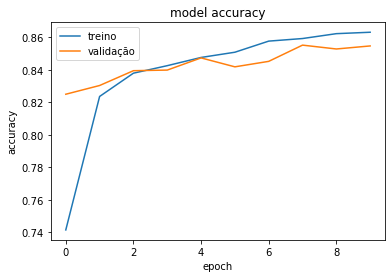

In [39]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

In [40]:
evaluation

[0.33340506117343904, 0.8557]